In [1]:
%cd notebooks
%cd ..

[Errno 2] No such file or directory: 'notebooks'
/home/ira/code/projects/deep-track/notebooks
/home/ira/code/projects/deep-track


In [2]:
import torch
from torch import nn

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import gym
import tqdm

In [3]:
from deep_track.utils.wrappers import AddPadding1D, AddShuffleNoise1D, AddBigNoise1D, AddResampledObs

In [12]:
N_REPEATS = 1
ENVS = ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "MountainCarContinuous-v0", "Pendulum-v0"]

env_id = ENVS[1] 

env_resampled = AddResampledObs(gym.make(env_id), n_repeats=N_REPEATS, shuffle_once_per_reset=True)
env_shuffled = AddShuffleNoise1D(gym.make(env_id), n_repeats=N_REPEATS, shuffle_once_per_reset=False)
env_noised = AddBigNoise1D(gym.make(env_id), n_repeats=N_REPEATS, bigness=1)
env_padded = AddPadding1D(gym.make(env_id), n_repeats=N_REPEATS)

In [13]:
def get_obs_tensors(env, steps=100):
    actions = []
    obss = []
    rewards = []

    obs = env.reset()
    obss.append(obs)

    for i in range(steps):
        a = env.action_space.sample()
        actions.append(a)

        obs, reward, done, _ = env.step(a)
        rewards.append(reward)
        obss.append(obs)

        if done:
            break    
    
    xx = torch.FloatTensor(obss).view(1, i+1+1, -1)
#     aa = torch.FloatTensor(actions).view(1, STEPS, np.sum(env.action_space.shape))
    aa = torch.FloatTensor(actions).view(1, i+1, -1)
    return xx, aa
    

## Simple RNNs

In [14]:
from deep_track.models.rnn import PredictorRNN

In [15]:
def learn_to_predict(env, updates=1000):
    xx, aa = get_obs_tensors(env, 1)

    net = PredictorRNN(xx.shape[-1], aa.shape[-1], hidden_size=16)
    opt = torch.optim.Adam(net.parameters(), lr=0.01)
    loss = torch.nn.modules.loss.MSELoss()

    bar = tqdm.tnrange(updates)
    stats = {}
    errs = []
    valids = []

    for i_update in bar:
        xx, aa = get_obs_tensors(env, 20)

        net.zero_grad()
        xx_in  = xx[:, :-1, :]
        xx_pred = net.forward(xx_in, aa)
        err = loss(xx[:, 1:, :], xx_pred)
        err.backward()
        opt.step()
        errs.append(err.data.item())
        stats['err'] = np.mean(errs[-updates//100:])

        if i_update % 1 == 0:
            xx, aa = get_obs_tensors(env, 100)
            xx_in  = xx[:, :-1, :]
            xx_pred = net.forward(xx_in, aa)
            err = loss(xx[:, 1:, :xx.shape[-1]//(N_REPEATS+1)], xx_pred[:, :, :xx.shape[-1]//(N_REPEATS+1)])
            valids.append(err.data.item())
            stats['valid'] = np.mean(valids[-updates//100:])

        bar.set_postfix(stats)

    plt.figure()
    plt.title("Errors on learning task and useful target")
    plt.plot(valids)
    plt.plot(errs)
    plt.legend([
        "useful target",
        "learning task",
    ])

    plt.figure()
    plt.title("Errors on useful target (zoomed in)")
    plt.plot(valids[updates//2:])
    plt.legend([
        "useful target"
    ])

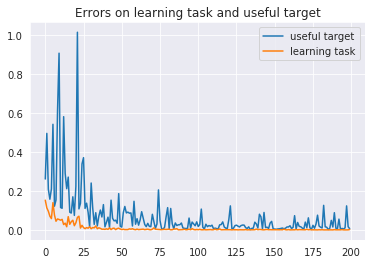

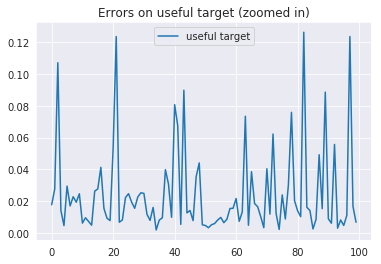

In [16]:
learn_to_predict(env_padded, 200)

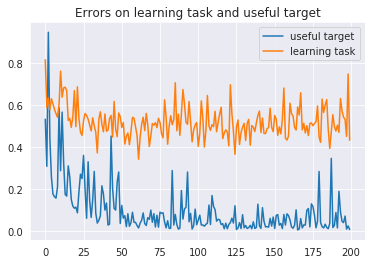

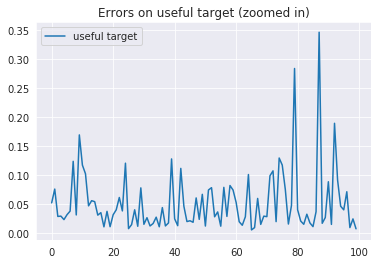

In [17]:
learn_to_predict(env_noised, 200)

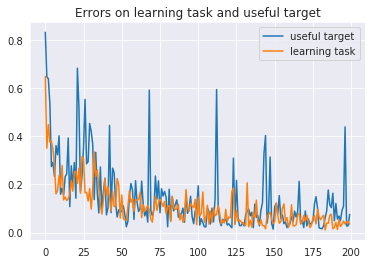

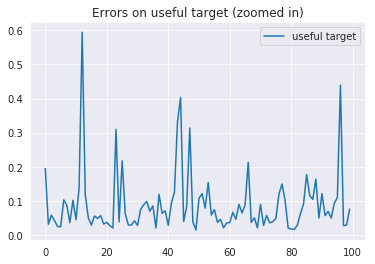

In [18]:
learn_to_predict(env_resampled, 200)

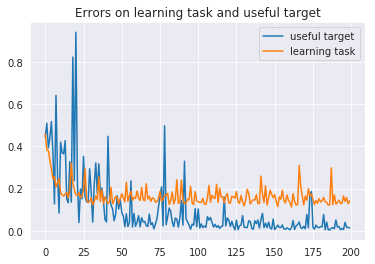

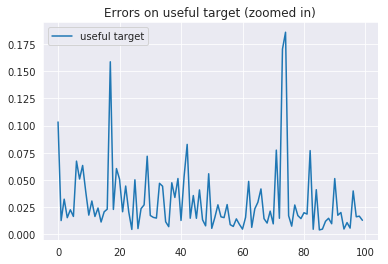

In [19]:
learn_to_predict(env_shuffled, 200)

## What next?
* how does this relate to RL experiments?
* how does batching affects learning?
* plot gradients (metric from open ai)